In [4]:
import numpy as np # 基础线性代数扩展包
import pandas as pd # 数据处理工具箱
df_bank = pd.read_csv("../input/bank-customer/BankCustomer.csv") # 读取文件
df_bank.head() # 显示文件前5行

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited
0,Kan Jian,Male,37,Tianjin,3,2,1,1,634,31937.37,137062,0
1,Xue Baochai,Female,39,Beijing,9,1,1,1,556,18144.95,110194,0
2,Mao Xi,Female,32,Beijing,9,1,1,1,803,10378.09,236311,1
3,Zheng Nengliang,Female,37,Tianjin,0,2,1,1,778,25564.01,129910,1
4,Zhi Fen,Male,55,Tianjin,4,3,1,0,547,3235.61,136976,1


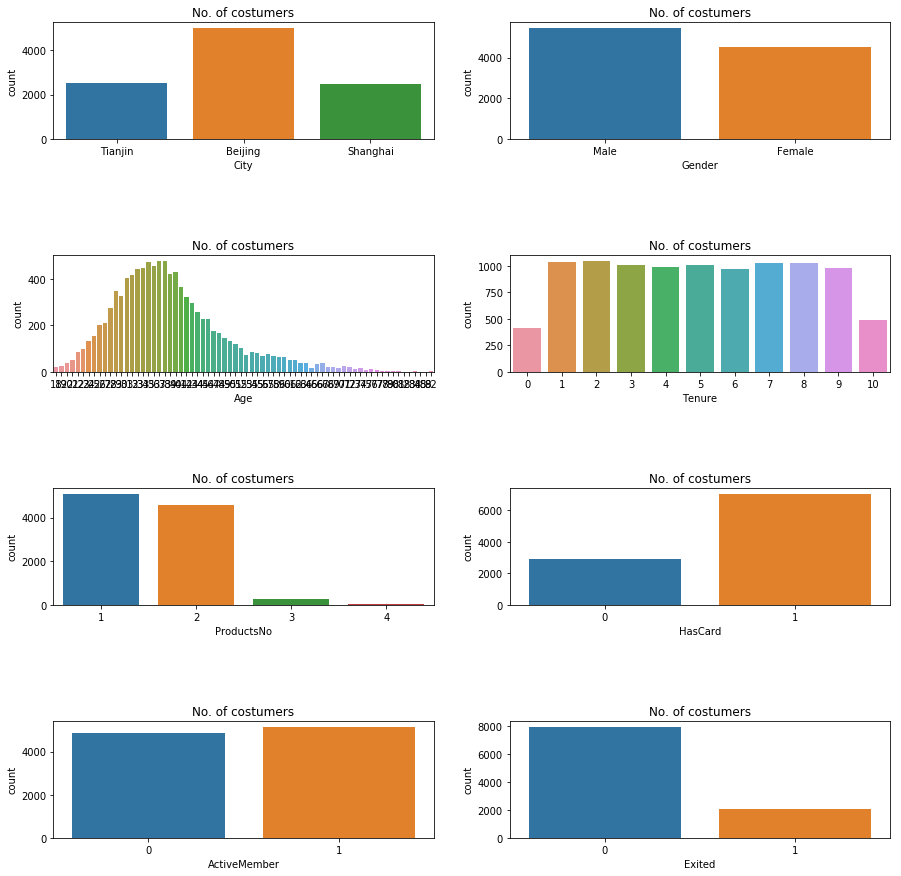

In [5]:
import matplotlib.pyplot as plt #导入matplotlib画图工具箱
import seaborn as sns #导入seaborn画图工具箱
# 显示不同特征的分布情况
features=[ 'City', 'Gender','Age','Tenure', 
           'ProductsNo', 'HasCard', 'ActiveMember', 'Exited']
fig=plt.subplots(figsize=(15,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = df_bank)
    plt.title("No. of costumers")

In [6]:
# 把二元类别文本数字化
df_bank['Gender'].replace("Female",0,inplace = True)
df_bank['Gender'].replace("Male",1,inplace=True)
# 显示数字类别
print("Gender unique values",df_bank['Gender'].unique())
# 把多元类别转换成多个二元哑变量，然后贴回原始数据集
d_city = pd.get_dummies(df_bank['City'], prefix = "City")
df_bank = [df_bank, d_city]
df_bank = pd.concat(df_bank, axis = 1)
# 构建特征和标签集合
y = df_bank['Exited']
X = df_bank.drop(['Name', 'Exited', 'City'], axis=1)
X.head() #显示新的特征集

Gender unique values [1 0]


,Gender,Age,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,City_Beijing,City_Shanghai,City_Tianjin
0,1,37,3,2,1,1,634,31937.37,137062,0,0,1
1,0,39,9,1,1,1,556,18144.95,110194,1,0,0
2,0,32,9,1,1,1,803,10378.09,236311,1,0,0
3,0,37,0,2,1,1,778,25564.01,129910,0,0,1
4,1,55,4,3,1,0,547,3235.61,136976,0,0,1


In [7]:
from sklearn.model_selection import train_test_split # 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size=0.2, random_state=0)

In [8]:
from sklearn.model_selection import StratifiedKFold # 导入K折验证工具
def Stacking(model,train,y,test,n_fold): # 定义Stacking函数
    folds = StratifiedKFold(n_splits=n_fold,random_state=1)
    train_pred = np.empty((0,1),float)
    test_pred = np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y.values):
        X_train,x_val = train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val = y.iloc[train_indices],y.iloc[val_indices]
        model.fit(X=X_train,y=y_train)
        train_pred = np.append(train_pred,model.predict(x_val))
    test_pred = np.append(test_pred,model.predict(test))
    return test_pred,train_pred

In [9]:
from sklearn.tree import DecisionTreeClassifier # 导入决策树模型
model1 = DecisionTreeClassifier(random_state=1) # model1-决策树
test_pred1 ,train_pred1 = Stacking(model=model1,n_fold=10,
                train=X_train,test=X_test,y=y_train)
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)
from sklearn.neighbors import KNeighborsClassifier # 导入kNN模型
model2 = KNeighborsClassifier() # model2-kNN
test_pred2 ,train_pred2 = Stacking(model=model2,n_fold=10,
                                 train=X_train,test=X_test,y=y_train)
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [10]:
# Stacking的实现-用逻辑回归模型预测新特征集
X_train_new = pd.concat([train_pred1, train_pred2], axis=1)
X_test_new = pd.concat([test_pred1, test_pred2], axis=1)
from sklearn.linear_model import LogisticRegression # 导入逻辑回归模型
model = LogisticRegression(random_state=1)
model.fit(X_train_new,y_train) # 拟合模型
model.score(X_test_new, y_test) # 分数评估

0.7915